# Sampling from a distribution over graphs

We will define a distribution over directed graphs, under the assumption that the vertices are known a-priori.

We'll focus on a class of distributions proposed by Mukherjee et al:

$$ P(G) \propto \exp \left( - \beta \cdot D(G, G^\prime) \right) $$

i.e., probability decreases exponentially with distance from some reference graph, $G^\prime$. 

The distance, $D$, could be any nonnegative notion of difference; but a useful default is Hamming distance between the graphs' edge sets.

In [1]:
include("DiGraph.jl")
include("NonGenerative.jl")
using Gen
using .DiGraphs
using .NonGenerative
using PyPlot

## Define a density over graphs

In [2]:
# in Gen, distributions are defined as singleton types:
struct GraphPriorDist <: Distribution{DiGraph} end
const graphpriordist = GraphPriorDist()

GraphPriorDist()

In [3]:
# define a hamming distance between graphs
function edge_hamming(g1::DiGraph{T}, g2::DiGraph{T}) where T
    return length(symdiff([g1.edges[i,:] for i=1:size(g1.edges)[1]],
                          [g2.edges[i,:] for i=1:size(g2.edges)[1]]))
end

# Define sampling methods for the graph distribution.
function Gen.random(gpd::GraphPriorDist, reference_graph::DiGraph{T}, beta::Number, distance_func::Function) where T
    return reference_graph
end

# if distance isn't specified, use hamming distance
function Gen.random(gpd::GraphPriorDist, reference_graph::DiGraph{T}, beta::Number) where T
    return Gen.random(gpd, reference_graph, beta, edge_hamming)
end

graphpriordist(reference_graph::DiGraph{T}, beta::Number) where T = Gen.random(graphpriordist, reference_graph, beta)

# Define a log-probability for this distribution.
function Gen.logpdf(gpd::GraphPriorDist, dg::DiGraph{T}, reference_graph::DiGraph{T}, beta::Number, distance_func::Function) where T
    return -beta * distance_func(dg, reference_graph)
end

# Again: use hamming distance by default
function Gen.logpdf(gpd::GraphPriorDist, dg::DiGraph{T}, reference_graph::DiGraph{T}, beta::Number) where T
    return Gen.logpdf(gpd, dg, reference_graph, beta, edge_hamming)
end


There are some issues with our construction:
1. This distribution is _unnormalized_. 
2. This distribution is _not generative_. It doesn't prescribe a sampling method.


However, our implementation should allow Gen's Metropolis-Hastings sampler to 'play nicely' with this distribution.
1. The distribution is unnormalized -- this means that the `logpdf` will not return correct values. However, the thing that _really_ matters in MH sampling is **change** in log-probability. And our logpdf implementation will correctly compute those.
2. The distribution isn't generative, but MH won't require us to explicitly sample from the distribution -- the whole point of MH is that it will allow us to sample from (unnormalized) log densities that have no generative description. As long as we provide a proposal distribution, we'll be fine.

### Example reference graph

We'll build an actual reference graph here, for illustrative purposes.

In [4]:
# Define a simple node type
struct Node
    name::String
    x::Float64
    y::Float64
end

In [5]:
# Define a mapping between string labels and nodes
vertex_dict = Dict("animal" => Node("animal", 0., 0.),
"mammal" => Node("mammal", -4., -1.),
"dog" => Node("dog", -5., -2.),
"cat" => Node("cat", -4., -2.),
"calico" => Node("calico", -4., -3.), 
"fish" => Node("fish", -1., -1.),
"bird" => Node("bird", 1., -1.),
"reptile" => Node("reptile", 3.0, -1.0),
"crocodile" => Node("crocodile", 4.0, -2.0),
"snake" => Node("snake", 2.0, -2.0),
"shark" => Node("shark", -2.0, -2.0),
"piranha" => Node("piranha", -0.0, -2.0)
);

In [6]:
example_tree = DiGraph(["mammal" "animal";
        "cat" "mammal";
        "calico" "cat";
        "dog" "mammal";
        "fish" "animal";
        "shark" "fish";
        "piranha" "fish";
        "bird" "animal";
        "reptile" "animal";
        "crocodile" "reptile";
        "snake" "reptile"])

DiGraph{String}(Set(["calico", "fish", "snake", "mammal", "dog", "reptile", "shark", "animal", "cat", "crocodile", "bird", "piranha"]), ["mammal" "animal"; "cat" "mammal"; … ; "crocodile" "reptile"; "snake" "reptile"])

### Some visualization machinery

We'll write some functions for visualizing graphs.

In [7]:
function visualize_vertices(digraph::DiGraph{T}, vertex_dict::Dict{T,Node}) where T
    xyn = [[vertex_dict[v].x vertex_dict[v].y vertex_dict[v].name] for v in digraph.vertices]
    xyn = vcat(xyn...,)
    scatter(xyn[:,1], xyn[:,2], s=120)
    for i=1:size(xyn)[1]
        annotate(xyn[i,3], (xyn[i,1], xyn[i,2]))
    end
end


function visualize_edges(digraph::DiGraph{T}, vertex_dict::Dict{T,Node}) where T
    for i=1:size(digraph.edges)[1]
        xs = [vertex_dict[digraph.edges[i,1]].x; vertex_dict[digraph.edges[i,2]].x]
        ys = [vertex_dict[digraph.edges[i,1]].y; vertex_dict[digraph.edges[i,2]].y]
        dx = xs[2] - xs[1]
        dy = ys[2] - ys[1]
        arrow(xs[1], ys[1], dx, dy, color="k", zorder=0, head_length=0.25, length_includes_head=true,
              head_width=0.125)
    end
end


function visualize_weighted_edges(vertex_dict::Dict{T,Node}, 
                                  weight_dict::Dict{T,Dict{T,Float64}}) where T
    for (orig, subdict) in pairs(weight_dict)
        for (dest, w) in pairs(subdict)
            xs = [vertex_dict[digraph.edges[i,1]].x; vertex_dict[digraph.edges[i,2]].x]
            ys = [vertex_dict[digraph.edges[i,1]].y; vertex_dict[digraph.edges[i,2]].y]
            dx = xs[2] - xs[1]
            dy = ys[2] - ys[1]
            arrow(xs[1], ys[1], dx, dy, color="k", zorder=0, head_length=0.25, length_includes_head=true,
                  head_width=0.125)
        end
    end
end


function visualize_digraph(digraph::DiGraph{T}, vertex_dict::Dict{T, Node}) where T 
    visualize_vertices(digraph, vertex_dict)
    visualize_edges(digraph, vertex_dict)
end


function visualize_weighted_digraph(digraph::DiGraph{T}, vertex_dict::Dict{T, Node},
                                    weight_dict::Dict{T,Dict{T,Float64}}) where T
    visualize_vertices(digraph, vertex_dict)
    visualize_weighted_edges(vertex_dict, weight_dict)
end

visualize_weighted_digraph (generic function with 1 method)

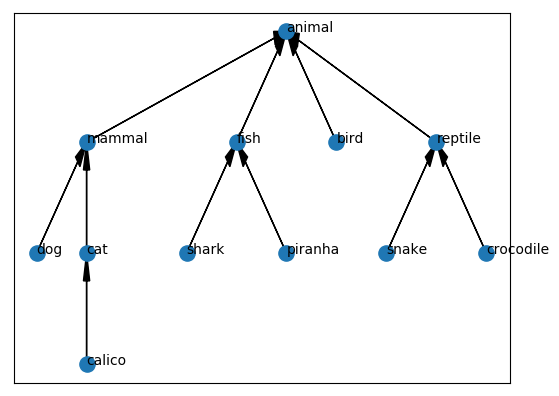

In [8]:
visualize_digraph(example_tree, vertex_dict)
xticks([])
yticks([])
show()

## Write a probabilistic program

Practically a one-liner. All it does is draw samples from our distribution -- there's no posterior inference going on here.

In [9]:
@gen function graph_generator(reference_graph::DiGraph{String}, beta::Float64)
    g = @trace(graphpriordist(reference_graph, beta), :graph)
    return g
end;

In order to sample from this, we'll need to define a proposal distribution that explores a space of directed graphs.

## A graph proposal distribution

Our first proposal distribution will explore the space of directed graphs in a mostly unconstrained fashion. 
That is, we won't enforce most graph properties: connectedness, acyclicity, in-degree, etc.
However, we *will* enforce a no-self-edge constraint (mostly for aesthetic reasons).

In [39]:
@gen function digraph_proposal(tr, expected_degree::Float64)
    
    G = copy(tr[:graph])
    ordered_vertices = sort([v for v in G.vertices])
    V = length(G.vertices)
    Dmax = V - 1
    
    # Choose a vertex at random
    u_idx = @trace(Gen.uniform_discrete(1,V), :u_idx)
    u = ordered_vertices[u_idx]
    ordered_out_neighbors = sort([v for v in out_neighbors(G, u)])
    ordered_in_neighbors = sort([v for v in in_neighbors(G, u)])
    ordered_neighbors = sort([v for v in union(ordered_out_neighbors, ordered_in_neighbors)])
    ordered_nonneighbors = sort([v for v in setdiff(G.vertices, ordered_neighbors) if v != u])
    
    # Compute the probability of adding an edge.
    Dout = length(ordered_out_neighbors)
    D = length(ordered_neighbors)
    t = log(2.0) / log(1.0*Dmax/(Dmax - expected_degree))
    add_prob = (1.0 - 1.0*D/Dmax)^t
    
    addedge = @trace(Gen.bernoulli(add_prob), :addedge)
    
    if addedge
        nonneighbor_idx = @trace(Gen.uniform_discrete(1,length(ordered_nonneighbors)), :nonneighbor_idx)
        add_edge!(G, u, ordered_nonneighbors[nonneighbor_idx])
    else
        
        remove_prob = 1.0*Dout/D
        removeedge = @trace(Gen.bernoulli(remove_prob), :removeedge)
        
        if removeedge
            outneighbor_idx = @trace(Gen.uniform_discrete(1, Dout), :outneighbor_idx)
            remove_edge!(G, u, ordered_out_neighbors[outneighbor_idx])
        else
            inneighbor_idx = @trace(Gen.uniform_discrete(1, length(ordered_in_neighbors)), :inneighbor_idx)
            v = ordered_in_neighbors[inneighbor_idx]
            remove_edge!(G, v, u)
            add_edge!(G, u, v)
        end
        
    end
    
    return G
    
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any, Float64], ##digraph_proposal#373, Bool[0, 0], false)

This proposal function, by itself, does not give Gen the ability to perform Metropolis-Hastings updates on our program traces.

For one thing, `digraph_proposal` doesn't even make a random choice of `:graph`. So it's incapable of updating the trace by itself.

Another, more fundamental, issue is that `digraph_proposal` does not provide enough information for Gen to compute Metropolis-Hastings acceptance probabilities:

$$\alpha = \text{min} \left(1, \frac{q(x|x^\prime)}{q(x^\prime | x)} \cdot \frac{P(x^\prime)}{P(x)} \right)$$

The issue arises in computing *backward* proposal probabilities, $q(x|x^\prime)$. 
Gen can't figure out, on its own, how to choose the backward step corresponding to our forward proposal.

To resolve both of these issues, we must provide an *involution* function which tells Gen how to update the trace and compute the backward step corresponding to any forward step.

In [40]:
function digraph_involution(tr, fwd_choices::Gen.ChoiceMap, G_new, proposal_args::Tuple)
   
    # Update the trace
    cmap = Gen.choicemap()
    cmap[:graph] = G_new
    new_tr, scorediff, _, discard = Gen.update(tr, get_args(tr), (NoChange(),), cmap)
   
    # Invert the random choices made by the proposal
    G_old = tr[:graph]
    bwd_choices = Gen.choicemap()
    
    new_edges = Set([G_new.edges[i,:] for i=1:size(G_new.edges)[1]])
    old_edges = Set([G_old.edges[i,:] for i=1:size(G_old.edges)[1]])
    ordered_vertices = sort([v for v in G_new.vertices])
    
    if length(new_edges) > length(old_edges) # edge was *added* -- must remove it now.
        new_edge = first(setdiff(new_edges, old_edges))
        u = new_edge[1]
        bwd_choices[:u_idx] = indexin([u], ordered_vertices)[1]
        bwd_choices[:addedge] = false
        bwd_choices[:removeedge] = true
        bwd_choices[:outneighbor_idx] = 1 # this is selected uniformly, so we don't really need an exact value.
                                          # We know for a fact that 1 will be a valid index, though.
        
    elseif length(new_edges) < length(old_edges) # edge was removed -- must add it now.
        old_edge = first(setdiff(old_edges, new_edges))
        u = old_edge[1]
        bwd_choices[:u_idx] = indexin([u], ordered_vertices)[1]
        bwd_choices[:addedge] = true
        bwd_choices[:nonneighbor_idx] = 1 # again, exact choice shouldn't (?) matter in this case.
        
    else # edge was reversed -- must reverse it back!
        new_edge = first(setdiff(new_edges, old_edges))
        u = new_edge[2]
        bwd_choices[:u_idx] = indexin([u], ordered_vertices)[1]
        bwd_choices[:addedge] = false
        bwd_choices[:removeedge] = false
        bwd_choices[:inneighbor_idx] = 1 # same deal ^^^
    end
    
    return new_tr, bwd_choices, scorediff
end

digraph_involution (generic function with 1 method)

In [230]:
tr, _ = Gen.generate(graph_generator, (example_tree, 2.5))
print(get_choices(tr))
println(length(tr[:graph].vertices), " vertices")
println(size(tr[:graph].edges)[1], " edges")

│
└── :graph : DiGraph{String}(Set(["calico", "fish", "snake", "mammal", "dog", "reptile", "shark", "animal", "cat", "crocodile", "bird", "piranha"]), ["mammal" "animal"; "cat" "mammal"; "calico" "cat"; "dog" "mammal"; "fish" "animal"; "shark" "fish"; "piranha" "fish"; "bird" "animal"; "reptile" "animal"; "crocodile" "reptile"; "snake" "reptile"])
12 vertices
11 edges


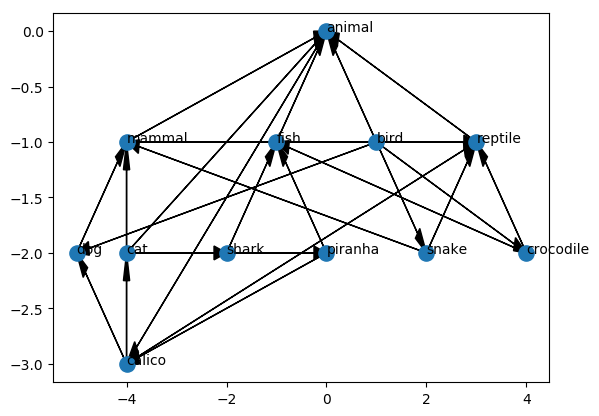

-32.5
0.2605


In [237]:
acceptances = zeros(2000)
for i=1:2000
    
    tr, acceptance = Gen.mh(tr, digraph_proposal, (0.5,), digraph_involution)
    acceptances[i] = 1.0*acceptance
    #visualize_digraph(tr[:graph], vertex_dict)
    #title("score: $(get_score(tr))")
    #println(get_score(tr))
end
println(get_score(tr))
println(sum(acceptances) / 2000.0)
visualize_digraph(tr[:graph], vertex_dict)